In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from pptx import Presentation
from pptx.util import Inches


def calc_jdk_rs_ratio(data: pd.Series) -> pd.Series:
    """
    Calculate the JDK RS Ratio.
    Parameters:
    data (pd.Series): A pandas series containing the data to calculate the ratio from.
    Returns:
    pd.Series: A pandas series containing the JDK RS Ratio.
    """
    # Calculate the 50-day and 200-day moving averages
    ma_50 = data.rolling(window=50).mean()
    ma_200 = data.rolling(window=200).mean()

    # Calculate the JDK RS Ratio
    jdk_rs_ratio = ma_50 / ma_200 - 1

    return jdk_rs_ratio


def calc_jdk_rs_momentum(jdk_rs_ratio: pd.Series) -> pd.Series:
    """
    Calculate the JDK RS Momentum.
    Parameters:
    jdk_rs_ratio (pd.Series): A pandas series containing the JDK RS Ratio to calculate the momentum from.
    Returns:
    pd.Series: A pandas series containing the JDK RS Momentum.
    """
    # Calculate the 20-day momentum
    jdk_rs_momentum = jdk_rs_ratio.diff(20)

    return jdk_rs_momentum


def calculate_jdk_rs(data: pd.Series) -> pd.Series:
    """
    Calculate the JDK RS Ratio and Momentum.
    Parameters:
    data (pd.Series): A pandas series containing the data to calculate the ratio and momentum from.
    Returns:
    pd.Series: A pandas series containing the JDK RS Ratio and Momentum.
    """
    if len(data) < 200:
        raise ValueError("Input data must have at least 200 data points")

    # Calculate the JDK RS Ratio
    jdk_rs_ratio = calc_jdk_rs_ratio(data)

    # Calculate the JDK RS Momentum
    jdk_rs_momentum = calc_jdk_rs_momentum(jdk_rs_ratio)

    # Concatenate the JDK RS Ratio and Momentum into a single series
    jdk_rs = pd.concat([jdk_rs_ratio, jdk_rs_momentum], axis=1)
    jdk_rs.columns = ['JDK RS Ratio', 'JDK RS Momentum']

    return jdk_rs

# Load the ETF ticker symbols from Excel
tickers_df = pd.read_excel('tickers.xlsx')
etfs = tickers_df['Ticker'].tolist()

# Download the ETF prices from Yahoo Finance
prices = pd.DataFrame()
for etf in etfs:
    try:
        today = datetime.today().strftime('%Y-%m-%d')
        data = yf.download(etf, start="2020-01-01", end=today)
        prices[etf] = data["Adj Close"]
    except Exception as e:
        print(f"Error retrieving data for {etf}: {e}")

# Calculate the RS ratios relative to SPY
spy_prices = prices["SPY"]
rs_ratios = pd.DataFrame()
for etf in etfs:
    rs_ratio = prices[etf] / spy_prices
    rs_ratios[etf] = rs_ratio

rs_ratios.columns = pd.MultiIndex.from_product([rs_ratios.columns,['RS Ratio']])

# Calculate the JDK RS ratios and momentums
jdk_rs_ratios = pd.DataFrame()
jdk_rs_momentums = pd.DataFrame()
for etf in etfs:
    jdk_rs_ratio = calc_jdk_rs_ratio(rs_ratios[[(etf,'RS Ratio')]])
    jdk_rs_ratio.columns = [(etf,'JDK RS Ratio')]
    jdk_rs_ratios = pd.concat([jdk_rs_ratios, jdk_rs_ratio], axis=1)
    
    jdk_rs_momentum = calc_jdk_rs_momentum(jdk_rs_ratio)
    jdk_rs_momentum.columns = [(etf,'JDK RS Momentum')]
    jdk_rs_momentums = pd.concat([jdk_rs_momentums, jdk_rs_momentum], axis=1)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

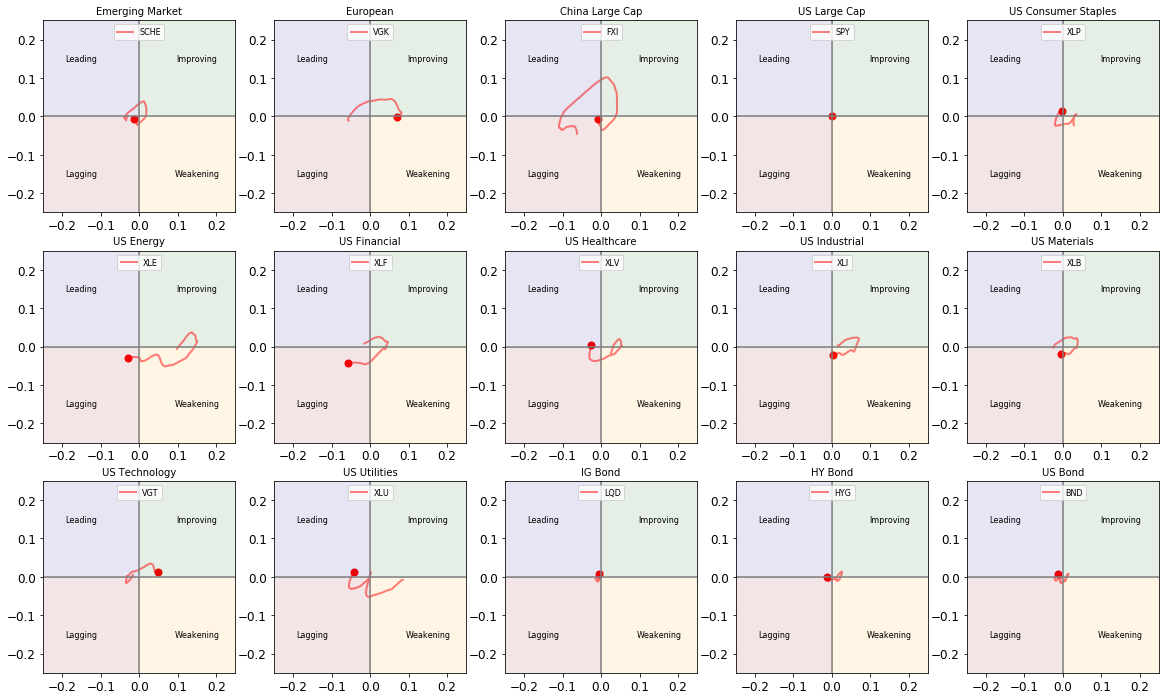

In [5]:
# Create a dictionary to map tickers to their full names
tickers_dict = dict(zip(tickers_df['Ticker'], tickers_df['Short Ticker Name']))

# Create a figure and axis object
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))

# Set the axis limits for all subplots
for ax in axs.flat:
    ax.set_xlim(-0.25, 0.25)
    ax.set_ylim(-0.25, 0.25)

# Loop through each ETF and plot its data in a separate subplot
for i, etf in enumerate(etfs):
        x, y = jdk_rs_ratios[(etf,'JDK RS Ratio')].iloc[-1], jdk_rs_momentums[(etf,'JDK RS Momentum')].iloc[-1]
        ax = axs[i//5, i%5]
        ax.scatter(x, y, color='red',alpha=1.00, linewidth=2)  # use a single color for all the plots

        # Define the number of days in the trailing line
        trailing_days = 150

        # Create a dataframe for the last n days of data
        trailing_data = rs_ratios.iloc[-trailing_days:]

        # Plot the trailing line for each ETF
        x_trailing = jdk_rs_ratios[(etf,'JDK RS Ratio')].loc[trailing_data.index]
        y_trailing = jdk_rs_momentums[(etf,'JDK RS Momentum')].loc[trailing_data.index]
        ax.plot(x_trailing, y_trailing, color='red', alpha=0.50, linewidth=2)

        # Define the colors for each quadrant
        colors2 = {"Leading": "darkgreen", "Lagging": "darkred", "Improving": "orange", "Weakening": "darkblue"}

        # Add rectangular patches to shade the quadrants
        ax.add_patch(mpl.patches.Rectangle((-1, -1), 1, 1, color=colors2["Lagging"], alpha=0.1))
        ax.add_patch(mpl.patches.Rectangle((0, -1), 1, 1, color=colors2["Improving"], alpha=0.1))
        ax.add_patch(mpl.patches.Rectangle((0, 0), 1, 1, color=colors2["Leading"], alpha=0.1))
        ax.add_patch(mpl.patches.Rectangle((-1, 0), 1, 1, color=colors2["Weakening"], alpha=0.1))

        # Add x-axis and y-axis lines
        ax.axhline(y=0, color='gray')
        ax.axvline(x=0, color='gray')
        
        # Add labels for the quadrants
        ax.text(-0.15, 0.15, "Leading", fontsize=8, ha="center", va="center")
        ax.text(-0.15, -0.15, "Lagging", fontsize=8, ha="center", va="center")
        ax.text(0.15, 0.15, "Improving", fontsize=8, ha="center", va="center")
        ax.text(0.15, -0.15, "Weakening", fontsize=8, ha="center", va="center")
        
        # Add title and tick labels
        ax.set_title(tickers_dict[etf], fontsize=10)
        ax.tick_params(labelsize=12)
        
        # Add legend
        ax.legend([etf], loc="upper center", fontsize=8)

# Show the plot
plt.show()

# Create a new PowerPoint presentation
prs = Presentation()
slide = prs.slides.add_slide(prs.slide_layouts[6])  # blank slide layout

# Insert the plot as an image into the first slide
fig.savefig('plot.png')  # save the plot as a PNG image
left = top = Inches(1)  # specify the position of the image on the slide
pic = slide.shapes.add_picture('plot.png', left, top)

# Save the PowerPoint presentation to a file
prs.save('my_presentation.pptx')


In [15]:
# create dictionaries to store ETFs in each quadrant
leading = {}
weakening = {}
lagging = {}
improving = {}

# determine the quadrant for each ETF based on their momentum and relative strength ratio values
for etf in jdk_rs_momentums.columns:
    if jdk_rs_momentums.loc[etf] > 0 and jdk_rs_ratios.loc[etf] > 0:
        leading[etf] = True
    elif jdk_rs_momentums.loc[etf] < 0 and jdk_rs_ratios.loc[etf] < 0:
        lagging[etf] = True
    elif jdk_rs_momentums.loc[etf] > 0 and jdk_rs_ratios.loc[etf] < 0:
        improving[etf] = True
    else:
        weakening[etf] = True
        
# print the quadrant for each ETF
for etf in jdk_rs_momentums.columns:
    if etf in leading:
        print(f"{etf} is in the Leading quadrant")
    elif etf in lagging:
        print(f"{etf} is in the Lagging quadrant")
    elif etf in improving:
        print(f"{etf} is in the Improving quadrant")
    else:
        print(f"{etf} is in the Weakening quadrant")


KeyError: 'SCHE'